# [E16]_Movie_Recommendation

# 목차
[01 데이터 전처리](#01-데이터-전처리)  
[02 미니 배치 구성](#02-미니-배치-구성)  
[03 모델 구성](#03-모델-구성)  
[04 모델 학습](#04-모델-학습)  
[05 회고](#05-회고)

## 01 데이터 전처리

In [1]:
import datetime as dt
from pathlib import Path
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

* pathlib : 파일경로를 설정하기 위한 패키지
* warnings.filterwarnings('ignore') : 발생되는 경고(warnings)를 출력 안되게 하는 설정

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


* data_path: Path : 함수에 입력되는 파라미터의 이름과 입력되는 파라미터의 형태 설정
* pd.read_csv(nrow) : nrow는 전체 데이터에서 선택할 데이터 조절 여기서는 None으로 전체 데이터 선택
* data.sort_values(['UserId', 'Time'], inplace=True) : 칼럼 리스트의 첫번째 값으로 먼저 sort한 후, 두번째 값으로 sort
* Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재

In [3]:
data.reset_index(drop=True, inplace = True)

In [4]:
data['Time'] = dt.datetime(1970,1,1)+pd.to_timedelta(data['Time'],unit='s')

In [5]:
data

,UserId,ItemId,Rating,Time
0,1,3186,4,2000-12-31 22:00:19
1,1,1270,5,2000-12-31 22:00:55
2,1,1721,4,2000-12-31 22:00:55
3,1,1022,5,2000-12-31 22:00:55
4,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29
1000205,6040,1921,4,2001-08-10 14:41:04
1000206,6040,1784,3,2001-08-10 14:41:04
1000207,6040,161,3,2001-08-10 14:41:26


### 01-01 데이터 EDA

In [6]:
UserId_length = data.groupby('UserId').size()

In [7]:
print("UserId Count : %s" % data['UserId'].nunique())
print("ItemId Count : %s" % data['ItemId'].nunique())


UserId Count : 6040
ItemId Count : 3706


In [8]:
print("UserId meadin : %s" % UserId_length.median())
print("UserId mean : %s" % UserId_length.mean())
print("UserId min : %s" % UserId_length.min())
print("UserId max : %s" % UserId_length.max())

UserId meadin : 96.0
UserId mean : 165.5975165562914
UserId min : 20
UserId max : 2314


In [9]:
length_count = UserId_length.groupby(UserId_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

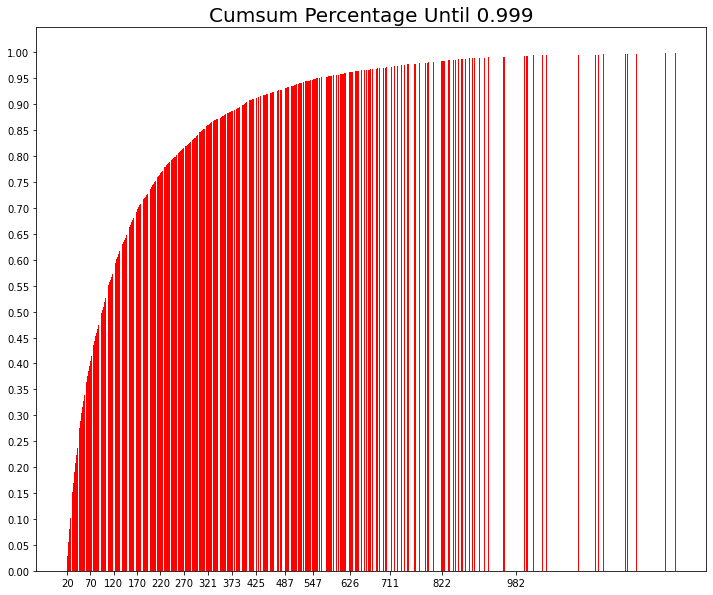

In [10]:
plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index[::50])
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

* data 유저별 시청한 영화 개수 시각화

In [11]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [12]:
month_ago = latest - dt.timedelta(60)     
data_1 = data[data['Time'] > month_ago]  
data_1.reset_index(drop=True, inplace = True)
data_1

,UserId,ItemId,Rating,Time
0,59,2997,4,2003-01-07 18:02:48
1,59,2147,2,2003-01-07 18:03:59
2,59,2369,4,2003-01-07 18:04:24
3,59,3408,4,2003-01-07 18:04:52
4,59,2712,3,2003-01-07 18:04:52
...,...,...,...,...
3379,5950,3948,4,2003-02-27 18:13:57
3380,5950,3578,4,2003-02-27 18:14:30
3381,5950,3793,3,2003-02-27 18:15:10
3382,5950,3555,2,2003-02-27 18:15:37


In [13]:
len(data_1)/len(data)

0.0033832928917856167

* 추천 시스템의 경우 최근 소비 트렌드를 학습하는 것이 중요
* 적절한 데이터의 수를 유지하며 최근 데이터만 사용하는 것이 중요
* 최근 2달 데이터로는 전체 데이터의 0.3%만 사용
* 우선 데이터 전체를 사용하고 점차 감소 시키는 방향으로 전환 > 소비 트렌드와 달리 영화 트렌드의 변화는 느리게 변화

In [14]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_view) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_view)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data
# shortest 이하의 만큼 존재하는 UserId는 제거
# seq 모델 구성이 예측이므로 1개 만의 아이템이 있는 유저는 모델 데이터셋 구성 불가

def cleanse_unpopular_item(data: pd.DataFrame, least_view):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_view].index
    data = data[data['ItemId'].isin(item_use)]
    return data
# ItemId가 너무 작은 경우에는 조회/사용/시청이 굉장히 적은 값으로 모델 학습에 부정적인 영향

In [15]:
min(data.groupby('UserId').size())

20

In [16]:
min(data.groupby('ItemId').size())

1

* 모델의 구조를 유저가 1개이상 영화를 봤을때, 다음 영화를 예측하는 것
* UseId 가 1인 경우는 한 유저가 영화를 하나만 봤다는 것을 의미 >> 모델 데이터셋 구조 구축 불가 >> 데이터 확인 결과 UserId는 20이 최소값 >> 제거 불필요
* ItemId 가 너무 작은 경우에는 인기가 굉장히 적은 이상치로 모델 학습에 부정적인 영향 >> 삭제 (5로 설정)

In [17]:
data_2 = cleanse_recursive(data, shortest=2, least_view=5)

In [18]:
data_2

,UserId,ItemId,Rating,Time
0,1,3186,4,2000-12-31 22:00:19
1,1,1270,5,2000-12-31 22:00:55
2,1,1721,4,2000-12-31 22:00:55
3,1,1022,5,2000-12-31 22:00:55
4,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29
1000205,6040,1921,4,2001-08-10 14:41:04
1000206,6040,1784,3,2001-08-10 14:41:04
1000207,6040,161,3,2001-08-10 14:41:26


In [19]:
data_2.sort_values('Time',inplace= True)

In [20]:
data_2.reset_index(drop=True, inplace=True)

In [21]:
data_2['Time']

0        2000-04-25 23:05:32
1        2000-04-25 23:05:54
2        2000-04-25 23:05:54
3        2000-04-25 23:06:17
4        2000-04-25 23:06:17
                 ...        
999606   2003-02-28 17:45:38
999607   2003-02-28 17:47:23
999608   2003-02-28 17:49:08
999609   2003-02-28 17:49:08
999610   2003-02-28 17:49:50
Name: Time, Length: 999611, dtype: datetime64[ns]

In [22]:
len(data_2)/len(data)

0.9994021249558842

In [23]:
long_session = UserId_length[UserId_length==UserId_length.max()].index[0]
data_2[data_2['UserId']==long_session]

,UserId,ItemId,Rating,Time
261336,4169,1268,5,2000-08-03 20:09:52
261337,4169,2617,4,2000-08-03 20:09:52
261338,4169,2653,4,2000-08-03 20:09:52
261339,4169,423,3,2000-08-03 20:09:52
261340,4169,2628,4,2000-08-03 20:09:52
...,...,...,...,...
985863,4169,3207,3,2002-06-15 20:23:26
985873,4169,3754,2,2002-06-15 20:52:27
985874,4169,1413,3,2002-06-15 21:03:51
985875,4169,494,4,2002-06-15 21:16:00


* UserId 중 Time이 동일한데 여러 영화에 평점을 매긴 데이터 확인
* UserId 가 같고 Time이 동일한 ItemId가 2개 이상이면 매크로로 간주 >> 해당 UserID 제거

In [24]:
data_2.loc[data_2.duplicated(['UserId','Time'],keep=False)].groupby('UserId').size()

UserId
1        31
2       100
3        35
4        19
5       174
       ... 
6036    871
6037    199
6038     10
6039    107
6040    261
Length: 6038, dtype: int64

* 데이터 확인결과 같은 시간에 2개이상 평점은 거의 모든 UserId에 존재
* 2개보다 많은 개수로 구성 하는 작업을 필요
* 우선 일반적인 데이터로 가정하고 진행 

## 01-02 train val test split

In [25]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    User_last_time = data.groupby('UserId')['Time'].max()
    User_in_train = User_last_time[User_last_time < final_time - dt.timedelta(n_days)].index
    User_in_test = User_last_time[User_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(User_in_train)]
    after_date = data[data['UserId'].isin(User_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [26]:
final_time = data['Time'].max()
print(final_time)

2003-02-28 17:49:50


In [27]:
User_last_time = data.groupby('UserId')['Time'].max()
print(User_last_time)

UserId
1      2001-01-06 23:39:11
2      2000-12-31 22:02:54
3      2000-12-31 21:35:04
4      2000-12-31 20:24:42
5      2000-12-31 07:09:45
               ...        
6036   2000-04-26 13:19:56
6037   2000-04-27 02:17:20
6038   2000-04-26 02:46:44
6039   2000-04-26 14:07:09
6040   2001-08-20 13:44:15
Name: Time, Length: 6040, dtype: datetime64[ns]


In [28]:
User_in_train = User_last_time[User_last_time < final_time - dt.timedelta(30)]
print(User_in_train)

UserId
1      2001-01-06 23:39:11
2      2000-12-31 22:02:54
3      2000-12-31 21:35:04
4      2000-12-31 20:24:42
5      2000-12-31 07:09:45
               ...        
6036   2000-04-26 13:19:56
6037   2000-04-27 02:17:20
6038   2000-04-26 02:46:44
6039   2000-04-26 14:07:09
6040   2001-08-20 13:44:15
Name: Time, Length: 5937, dtype: datetime64[ns]


In [29]:
train, test = split_by_date(data_2,n_days = 30)
train, val = split_by_date(train,n_days = 30)

In [30]:
train

,UserId,ItemId,Rating,Time
0,6040,858,4,2000-04-25 23:05:32
1,6040,593,5,2000-04-25 23:05:54
2,6040,2384,4,2000-04-25 23:05:54
3,6040,1961,4,2000-04-25 23:06:17
4,6040,2019,5,2000-04-25 23:06:17
...,...,...,...,...
996194,2342,3864,5,2002-12-29 21:04:19
996221,411,3916,3,2002-12-30 01:36:48
996222,753,1623,4,2002-12-30 01:48:12
996223,411,3326,2,2002-12-30 01:53:41


In [31]:
print(len(train),len(val),len(test))

919209 29477 50925


In [32]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [33]:
stats_info(train, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 919209
	 Sessions: 5858
	 Items: 3416
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-12-30 02:26:14

* valid Set Stats Info
	 Events: 29477
	 Sessions: 79
	 Items: 2960
	 First Time : 2000-05-05 17:20:21
	 Last Time : 2003-01-29 03:00:40

* test Set Stats Info
	 Events: 50925
	 Sessions: 103
	 Items: 3172
	 First Time : 2000-05-01 11:15:13
	 Last Time : 2003-02-28 17:49:50



In [34]:
id2idx = {item_id : index for index, item_id in enumerate(train['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

train = indexing(train, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [35]:
train.head()

,UserId,ItemId,Rating,Time,item_idx
0,6040,858,4,2000-04-25 23:05:32,0
1,6040,593,5,2000-04-25 23:05:54,1
2,6040,2384,4,2000-04-25 23:05:54,2
3,6040,1961,4,2000-04-25 23:06:17,3
4,6040,2019,5,2000-04-25 23:06:17,4


In [36]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

train.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 02 미니 배치 구성

<img src = "https://d3s0tskafalll9.cloudfront.net/media/images/input2.max-800x600.png">

In [37]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [38]:
train['UserId'].nunique()

5858

In [39]:
offsets = np.zeros(train['UserId'].nunique() + 1, dtype=np.int32)
offsets[1:] = train.groupby('UserId').size().cumsum()

In [40]:
offsets

array([     0,     53,    182, ..., 918745, 918868, 919209], dtype=int32)

In [41]:
train_dataset = SessionDataset(train)
train_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
0,6040,858,4,2000-04-25 23:05:32,0
1,6040,593,5,2000-04-25 23:05:54,1
2,6040,2384,4,2000-04-25 23:05:54,2
3,6040,1961,4,2000-04-25 23:06:17,3
4,6040,2019,5,2000-04-25 23:06:17,4
5,6040,573,4,2000-04-25 23:07:36,5
6,6040,1419,3,2000-04-25 23:07:36,6
7,6040,213,5,2000-04-25 23:07:36,7
8,6040,3111,5,2000-04-25 23:07:36,8
9,6040,3505,4,2000-04-25 23:07:36,9


In [42]:
train_dataset.click_offsets

array([     0,     53,    182, ..., 918745, 918868, 919209], dtype=int32)

* click_offsets은 userid가 바뀌는 index값

In [43]:
train_dataset.session_idx

array([   0,    1,    2, ..., 5855, 5856, 5857])

In [44]:
len(train_dataset.session_idx)

5858

In [ ]:
first_iters = np.arange(50)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
last_session = 49    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
start = train_dataset.click_offsets[train_dataset.session_idx[first_iters]]# data 상에서 session이 시작된 위치를 가져옵니다.
end = train_dataset.click_offsets[train_dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.

In [ ]:
train_dataset.session_idx

In [ ]:
train_dataset.click_offsets

In [ ]:
train_dataset.session_idx[first_iters]

In [ ]:
val

In [ ]:
batch_size =2048

In [ ]:
val_dataset = SessionDataset(val)

In [ ]:
val_dataset.df

In [ ]:
val_dataset.session_idx

In [ ]:
val_dataset.click_offsets

In [ ]:
first_iters 

In [ ]:
first_iters = np.arange(2048)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
last_session = 2047    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
start = val_dataset.click_offsets[val_dataset.session_idx[first_iters]]# data 상에서 session이 시작된 위치를 가져옵니다.
end = val_dataset.click_offsets[val_dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.

In [45]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]# data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [ ]:
np.arange(2048)

In [ ]:
train_dataset.session_idx[np.arange(2048)]

In [ ]:
train_data_loader = SessionDataLoader(train_dataset, batch_size=4)
train_dataset.df.head(15)

In [ ]:
iter_ex = iter(train_data_loader)

In [ ]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

## 03 모델 구성

<img src = https://d3s0tskafalll9.cloudfront.net/media/images/model.max-800x600.png>

In [46]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [47]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [48]:
class Args:
    def __init__(self, train, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = train
        self.val = val
        self.test = test
        self.num_items = train['ItemId'].nunique()
        self.num_sessions = train['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [ ]:
len(train[:-1705]),len(val),len(test)

In [ ]:
len(train[:-1705])%2048,len(val)%2048,len(test)%2048

In [49]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      520200    
_________________________________________________________________
dropout (Dropout)            (64, 50)                  0         
_________________________________________________________________
dense (Dense)                (64, 3416)                174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


## 04 모델 학습

In [50]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [51]:
train_model(model, args)

Evaluation:  29%|██▊       | 131/459 [00:38<01:35,  3.43it/s]


	 - Recall@20 epoch 1: 0.180224
	 - MRR@20    epoch 1: 0.042863



Evaluation:  29%|██▊       | 131/459 [00:37<01:32,  3.54it/s]


	 - Recall@20 epoch 2: 0.225429
	 - MRR@20    epoch 2: 0.051203



Evaluation:  29%|██▊       | 131/459 [00:36<01:32,  3.56it/s]

	 - Recall@20 epoch 3: 0.233421
	 - MRR@20    epoch 3: 0.054089



## 05 회고

* 모델 정확도가 매우 낮아서 아쉽다
* 데이터 구성하는 것이 어려웠다
* rating을 사용하는 방안에 대해서 고민했으나 적용하지 못했다.